In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from acquire import get_curriculum_data

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = get_curriculum_data()
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   ip          900223 non-null  object 
 5   name        847330 non-null  object 
 6   start_date  847330 non-null  object 
 7   end_date    847330 non-null  object 
 8   program_id  847330 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 68.7+ MB


,date,time,path,user_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0


##### 1 - Drop single Nan record (raw df: index # 506304)

In [3]:
df = df.drop(df.index[506305])
df.shape

(900222, 9)

##### 2 - Drop all program_id == 4  (5 records)

In [4]:
df = df[df.program_id != 4]
df.shape

(900217, 9)

##### 3 - Split up the path to drill down to units, lessons and beyond

First, user a new dataframe to create the following:

In [5]:
splits = df.path.str.split('/', expand=True)
splits.head()

,0,1,2,3,4,5,6,7
0,,,None,None,None,None,None,None
1,java-ii,None,None,None,None,None,None,None
2,java-ii,object-oriented-programming,None,None,None,None,None,None
3,slides,object_oriented_programming,None,None,None,None,None,None
4,javascript-i,conditionals,None,None,None,None,None,None


Now create a column telling how many rows there are

In [6]:
# Create a column that indicates how many columns of data that row of splits has
splits['row_type'] = 8 - (splits.isnull().sum(axis=1))


In [7]:
#Unit is the highest level
splits['unit'] = splits[0]

In [8]:
# Subunit, sometimes found in second row
splits['subunit'] = np.where(splits.row_type > 2, splits[1],splits[7])

In [9]:
# Next, lesson, which is in the first or third row
splits['lesson'] = np.where(splits.row_type == 2, splits[1], splits[2])

In [10]:
# And finally, the rest of the path
splits['other'] = np.where(splits.row_type ==8,
                           splits[3] + '/' + splits[4] + '/' + splits[5] + '/' + splits[6] + '/' + splits[7],
                           np.where(splits.row_type == 7, 
                               splits[3] + '/' + splits[4] + '/' + splits[5] + '/' + splits[6],
                               np.where(splits.row_type == 6,
                                        splits[3] + '/' + splits[4] + '/' + splits[5],
                                        np.where(splits.row_type == 5,
                                                 splits[3] + '/' + splits[4], splits[3]))))

In [11]:
splits.head(2)

,0,1,2,3,4,5,6,7,row_type,unit,subunit,lesson,other
0,,,None,None,None,None,None,None,2,,None,,None
1,java-ii,None,None,None,None,None,None,None,1,java-ii,None,None,None


In [12]:
splits = splits[['unit','subunit','lesson','other']]

In [13]:
splits.sample(2)

,unit,subunit,lesson,other
275641,spring,None,None,None
636129,spring,None,None,None


##### Merge with original dataframe

In [14]:
df = df.merge(splits, left_index=True, right_index = True)
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900217 entries, 0 to 900222
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900217 non-null  object 
 1   time        900217 non-null  object 
 2   path        900217 non-null  object 
 3   user_id     900217 non-null  int64  
 4   ip          900217 non-null  object 
 5   name        847324 non-null  object 
 6   start_date  847324 non-null  object 
 7   end_date    847324 non-null  object 
 8   program_id  847324 non-null  float64
 9   unit        900217 non-null  object 
 10  subunit     226868 non-null  object 
 11  lesson      731929 non-null  object 
 12  other       26308 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 128.4+ MB


,date,time,path,user_id,ip,name,start_date,end_date,program_id,unit,subunit,lesson,other
475464,2020-03-05,09:29:01,jquery/events/keyboard-events,571,97.105.19.58,Fortuna,2020-01-13,2020-06-23,2.0,jquery,events,keyboard-events,None
434090,2020-01-21,08:50:41,javascript-ii,535,97.105.19.58,Europa,2019-11-04,2020-04-17,2.0,javascript-ii,None,None,None
890829,2021-04-15,10:33:19,html-css/css-ii/media-queries,927,136.50.58.119,Neptune,2021-03-15,2021-09-03,2.0,html-css,css-ii,media-queries,None
444555,2020-02-03,09:11:06,spring/fundamentals/security,506,97.105.19.58,Deimos,2019-09-16,2020-02-27,2.0,spring,fundamentals,security,None
637731,2020-08-12,16:11:54,html-css,514,67.11.193.143,Staff,2014-02-04,2014-02-04,2.0,html-css,None,None,None


##### 3 - Remove all those whose name/cohort are 'Staff' and set them aside in seperate dataframe.

In [15]:
df_staff = df[df.name == 'Staff']
df_staff.info()
df_staff.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84031 entries, 166284 to 900222
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        84031 non-null  object 
 1   time        84031 non-null  object 
 2   path        84031 non-null  object 
 3   user_id     84031 non-null  int64  
 4   ip          84031 non-null  object 
 5   name        84031 non-null  object 
 6   start_date  84031 non-null  object 
 7   end_date    84031 non-null  object 
 8   program_id  84031 non-null  float64
 9   unit        84031 non-null  object 
 10  subunit     16141 non-null  object 
 11  lesson      66112 non-null  object 
 12  other       2185 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 9.0+ MB


,date,time,path,user_id,ip,name,start_date,end_date,program_id,unit,subunit,lesson,other
166284,2018-12-06,14:15:29,appendix/further-reading/java/intellij-tomcat-...,53,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0,appendix,further-reading,java,intellij-tomcat-configuration
166294,2018-12-06,14:25:40,javascript-i,314,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0,javascript-i,None,None,None
166295,2018-12-06,14:25:41,javascript-i/coffee-project,314,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0,javascript-i,None,coffee-project,None
166521,2018-12-06,15:31:29,spring,40,170.248.173.247,Staff,2014-02-04,2014-02-04,2.0,spring,None,None,None
166522,2018-12-06,15:31:33,spring/fundamentals/security,40,170.248.173.247,Staff,2014-02-04,2014-02-04,2.0,spring,fundamentals,security,None


In [16]:
df = df[df.name != 'Staff']
df.shape

(816186, 13)

##### 4 - Impute User Cohorts

This is a good time to create the lists for each program_id, noting Web Dev = concatintating those two lists:

In [17]:
web_dev_1 = df[df.program_id == 1].name.unique()
web_dev_2 = df[df.program_id == 2].name.unique()
data_science = df[df.program_id == 3].name.unique()
print(f'web_dev_1 cohorts:{len(web_dev_1)}, web_dev_2 cohorts:{len(web_dev_2)}, data_science cohorts:{len(data_science)}')
print(f'Total = {len(web_dev_1) + len(web_dev_2) + len(data_science)} cohorts')

web_dev_1 cohorts:13, web_dev_2 cohorts:27, data_science cohorts:5
Total = 45 cohorts


### Make a dataframe with cohort, low user id and high user id

First make a list of all cohorts

In [18]:
cohort_list = df.name.unique()

Now make a dataframe of just those in cohorts

In [19]:
has_cohort = df[df['name'].isnull() != True]

Make a dataframe with the ranges of user_ids for each cohort

In [20]:
cohort_ranges= []
for cohort in cohort_list:
    entry = {}
    entry['Cohort'] = cohort
    entry['Low user_id'] = has_cohort[has_cohort.name == cohort].user_id.min()
    entry['High user_id'] = has_cohort[has_cohort.name == cohort].user_id.max()
    cohort_ranges.append(entry)
pd.DataFrame(cohort_ranges)

,Cohort,Low user_id,High user_id
0,Hampton,1.0,646.0
1,Teddy,2.0,459.0
2,Sequoia,10.0,346.0
3,Arches,11.0,402.0
4,Niagara,21.0,322.0
5,Pinnacles,26.0,611.0
6,Quincy,37.0,610.0
7,NaN,NaN,NaN
8,Kings,50.0,318.0
9,Lassen,53.0,852.0


### *This led to me to want to look at boxplots of cohort as x vs user_ids on left.  Will use only those from has_cohort*

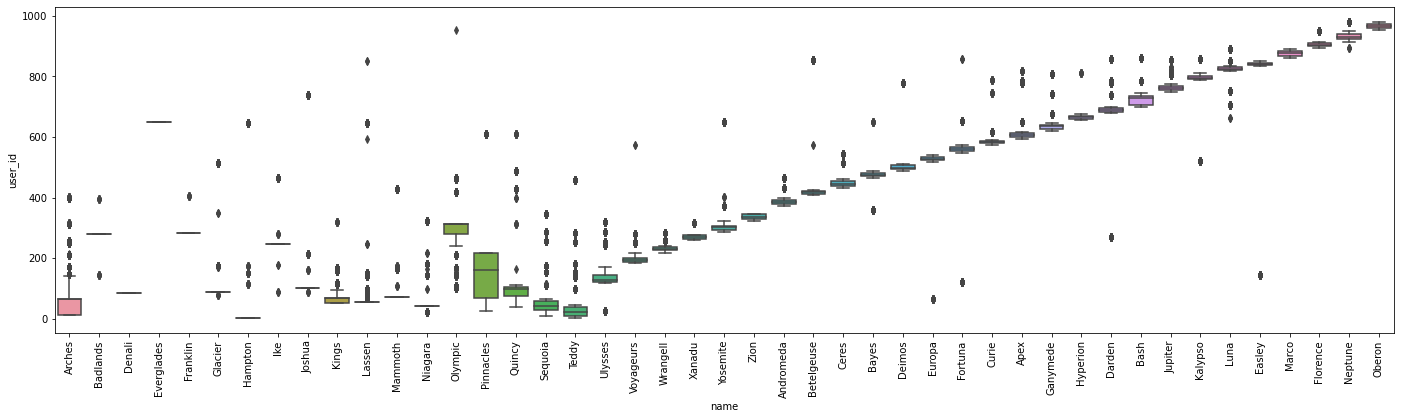

In [21]:
plt.figure(figsize = (24,6))
sns.boxplot(data = has_cohort.sort_values('start_date'), x = 'name', y = 'user_id')
plt.xticks(rotation = 90)
plt.show()

## Well that seems to indicate there are outliers in virtually every cohort.  Good to know - this is a great #8 question and answer!

Going back to the cohort imputation:

Creating a dataframe for all user_ids without a cohort.

In [22]:
no_cohort = df[df['name'].isnull()  == True]
no_cohort

,date,time,path,user_id,ip,name,start_date,end_date,program_id,unit,subunit,lesson,other
411,2018-01-26,16:46:16,/,48,97.105.19.61,NaN,NaN,NaN,NaN,,None,,None
412,2018-01-26,16:46:24,spring/extra-features/form-validation,48,97.105.19.61,NaN,NaN,NaN,NaN,spring,extra-features,form-validation,None
425,2018-01-26,17:54:24,/,48,97.105.19.61,NaN,NaN,NaN,NaN,,None,,None
435,2018-01-26,18:32:03,/,48,97.105.19.61,NaN,NaN,NaN,NaN,,None,,None
436,2018-01-26,18:32:17,mysql/relationships/joins,48,97.105.19.61,NaN,NaN,NaN,NaN,mysql,relationships,joins,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
899897,2021-04-21,12:49:00,javascript-ii,717,136.50.102.126,NaN,NaN,NaN,NaN,javascript-ii,None,None,None
899898,2021-04-21,12:49:02,javascript-ii/es6,717,136.50.102.126,NaN,NaN,NaN,NaN,javascript-ii,None,es6,None
899899,2021-04-21,12:51:27,javascript-ii/map-filter-reduce,717,136.50.102.126,NaN,NaN,NaN,NaN,javascript-ii,None,map-filter-reduce,None
899900,2021-04-21,12:52:37,javascript-ii/promises,717,136.50.102.126,NaN,NaN,NaN,NaN,javascript-ii,None,promises,None


In [23]:
# Let's get a list of all user_ids without cohort name
no_cohort_list = no_cohort.user_id.unique()
no_cohort_list

array([ 48,  54,  58,  59,  61,  62,  63,  73,  74,  78,  79,  86,  88,
        89, 100, 103, 111, 137, 166, 176, 213, 247, 317, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 372, 375, 403, 406, 429, 544,  64, 713,
       714, 715, 716, 717, 718, 663, 719, 720, 721, 722, 723, 724, 725,
       726, 727, 728, 729, 346, 731, 736, 644, 744, 782, 810, 814, 815])

Now we have to copy of the main df dataframe replacing nulls with 'X'

In [24]:
df_X = df.copy()
df_X['name'] = np.where(df_X.name.isnull() == True, 'X',df_X.name)
df_X

,date,time,path,user_id,ip,name,start_date,end_date,program_id,unit,subunit,lesson,other
0,2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,,None,,None
1,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,None,None,None
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,None,object-oriented-programming,None
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,slides,None,object_oriented_programming,None
4,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,None,conditionals,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
900210,2021-04-21,16:36:09,jquery/personal-site,869,136.50.98.51,Marco,2021-01-25,2021-07-19,2.0,jquery,None,personal-site,None
900211,2021-04-21,16:36:34,html-css/css-ii/bootstrap-grid-system,948,104.48.214.211,Neptune,2021-03-15,2021-09-03,2.0,html-css,css-ii,bootstrap-grid-system,None
900212,2021-04-21,16:37:48,java-iii,834,67.11.50.23,Luna,2020-12-07,2021-06-08,2.0,java-iii,None,None,None
900213,2021-04-21,16:38:14,java-iii/servlets,834,67.11.50.23,Luna,2020-12-07,2021-06-08,2.0,java-iii,None,servlets,None


In [25]:
user_list = []

#loop over each, skipping over 'problem' user_ids 
for user in no_cohort_list:
    inlist = {}
    inlist['prev_user_cohort'] = df_X[df_X.user_id == (user-1)].name.max()
    inlist['prev_user_program'] = df_X[df_X.user_id == (user-1)].program_id.max()
    inlist['user_id'] = user
    inlist['next_user_cohort'] = df_X[df_X.user_id == (user+1)].name.max()
    inlist['next_user_program'] = df_X[df_X.user_id == (user+1)].program_id.max()
    inlist['total_accesses'] = df_X[df_X.user_id == user].date.count()
    user_list.append(inlist)
df_no_cohort_user = pd.DataFrame(user_list).set_index('user_id')
df_no_cohort_user

,prev_user_cohort,prev_user_program,next_user_cohort,next_user_program,total_accesses
user_id,,,,,
48,Sequoia,2.0,Sequoia,2.0,1581
54,Lassen,1.0,Sequoia,2.0,146
58,Sequoia,2.0,X,NaN,462
59,X,NaN,Arches,1.0,42
61,Arches,1.0,X,NaN,816
...,...,...,...,...,...
744,Bash,2.0,NaN,NaN,69
782,Darden,3.0,Darden,3.0,370
810,Ganymede,2.0,Kalypso,2.0,709


Now that we have this, we can get suggested cohorts - that is cohorts who are surrounded by others.

In [26]:
df_no_cohort_user['suggested_cohort'] = np.where(df_no_cohort_user.prev_user_cohort != df_no_cohort_user.next_user_cohort,'Cannot Impute',
                                                np.where(df_no_cohort_user.prev_user_cohort == 'X', 'Cannot Impute' ,df_no_cohort_user.prev_user_cohort)) 
suggested_imputes = df_no_cohort_user[df_no_cohort_user.suggested_cohort != 'Cannot Impute']
suggested_imputes = suggested_imputes[['suggested_cohort','prev_user_program']].rename(columns = {'prev_user_program':'program'})

In [27]:
suggested_imputes

,suggested_cohort,program
user_id,,
48,Sequoia,2.0
375,Andromeda,2.0
663,Hyperion,2.0
346,Zion,2.0
731,Bash,2.0
736,Bash,2.0
644,Ganymede,2.0
782,Darden,3.0


##### USE THIS DATAFRAME TO INPUTE ON THE MAIN DF

Quick check on imputation (these should all have their respective programs type units)

In [28]:
for user in suggested_imputes.index:
    print('User ID:',user)
    print(df[df.user_id == user].unit.value_counts().head())
    print('\n-----\n')

User ID: 48
javascript-i    247
spring          185
mysql           172
java-ii         162
html-css        155
Name: unit, dtype: int64

-----

User ID: 375
spring          245
mysql           185
html-css        184
javascript-i    171
java-iii        166
Name: unit, dtype: int64

-----

User ID: 663
html-css        172
javascript-i     48
examples         27
                 21
toc              20
Name: unit, dtype: int64

-----

User ID: 346
html-css        520
toc             466
javascript-i    458
                283
jquery          217
Name: unit, dtype: int64

-----

User ID: 731
html-css        177
javascript-i    143
toc              88
                 62
examples         41
Name: unit, dtype: int64

-----

User ID: 736
javascript-i    350
spring          349
html-css        337
                193
mysql           192
Name: unit, dtype: int64

-----

User ID: 644
java-iii        245
mysql           221
html-css        220
javascript-i    191
search          173
Name: unit, 

Create a dataframe to hold cohort info

In [29]:
sd = pd.DataFrame(df.groupby('name').start_date.min())
ed = pd.DataFrame(df.groupby('name').end_date.max())
pid = pd.DataFrame(df.groupby('name').program_id.mean())

In [30]:
cohort_info = sd.merge(ed, on='name').merge(pid, on='name')
cohort_info

,start_date,end_date,program_id
name,,,
Andromeda,2019-03-18,2019-07-30,2.0
Apex,2020-02-24,2020-07-29,2.0
Arches,2014-02-04,2014-04-22,1.0
Badlands,2014-06-04,2014-08-22,1.0
Bash,2020-07-20,2021-01-21,2.0
Bayes,2019-08-19,2020-01-30,3.0
Betelgeuse,2019-05-28,2019-10-08,2.0
Ceres,2019-07-15,2019-12-11,2.0
Curie,2020-02-03,2020-07-07,3.0


##### All of these check out with the type of program their cohort represents, so feel ok putting them into the main dataframe.

In [31]:
suggested_imputes = suggested_imputes.merge(cohort_info, left_on='suggested_cohort', right_on='name').set_index(suggested_imputes.index)
suggested_imputes = suggested_imputes.drop(columns = 'program')

In [32]:
suggested_imputes

,suggested_cohort,start_date,end_date,program_id
user_id,,,,
48,Sequoia,2017-09-27,2018-02-15,2.0
375,Andromeda,2019-03-18,2019-07-30,2.0
663,Hyperion,2020-05-26,2020-11-10,2.0
346,Zion,2019-01-22,2019-06-04,2.0
731,Bash,2020-07-20,2021-01-21,2.0
736,Bash,2020-07-20,2021-01-21,2.0
644,Ganymede,2020-03-23,2020-08-20,2.0
782,Darden,2020-07-13,2021-01-12,3.0


In [33]:
df = df.merge(suggested_imputes, how='left', on='user_id')
df['name'] = np.where(df.name.isnull()==True, df.suggested_cohort, df.name)
df['start_date'] = np.where(df.start_date_x.isnull()==True, df.start_date_y, df.start_date_x)
df['end_date'] = np.where(df.end_date_x.isnull()==True, df.end_date_y, df.end_date_x)
df['program_id'] = np.where(df.program_id_x.isnull()==True, df.program_id_y, df.program_id_x)

In [34]:
df = df.drop(columns = ['start_date_x','end_date_x','program_id_x','suggested_cohort','start_date_y','end_date_y','program_id_y'])

In [35]:
df.info()
df.head()
df[df.user_id == 345]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816186 entries, 0 to 816185
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        816186 non-null  object 
 1   time        816186 non-null  object 
 2   path        816186 non-null  object 
 3   user_id     816186 non-null  int64  
 4   ip          816186 non-null  object 
 5   name        769785 non-null  object 
 6   unit        816186 non-null  object 
 7   subunit     210727 non-null  object 
 8   lesson      665817 non-null  object 
 9   other       24123 non-null   object 
 10  start_date  769785 non-null  object 
 11  end_date    769785 non-null  object 
 12  program_id  769785 non-null  float64
dtypes: float64(1), int64(1), object(11)
memory usage: 87.2+ MB


,date,time,path,user_id,ip,name,unit,subunit,lesson,other,start_date,end_date,program_id
180333,2019-01-23,08:25:16,/,345,97.105.19.58,Zion,,None,,None,2019-01-22,2019-06-04,2.0
180349,2019-01-23,08:42:19,/,345,97.105.19.58,Zion,,None,,None,2019-01-22,2019-06-04,2.0
180350,2019-01-23,08:42:31,toc,345,97.105.19.58,Zion,toc,None,None,None,2019-01-22,2019-06-04,2.0
180358,2019-01-23,08:50:14,/,345,97.105.19.58,Zion,,None,,None,2019-01-22,2019-06-04,2.0
180361,2019-01-23,08:52:02,/,345,97.105.19.58,Zion,,None,,None,2019-01-22,2019-06-04,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249345,2019-05-01,15:18:56,spring/fundamentals/views,345,97.105.19.58,Zion,spring,fundamentals,views,None,2019-01-22,2019-06-04,2.0
251325,2019-05-05,19:15:47,/,345,136.49.24.186,Zion,,None,,None,2019-01-22,2019-06-04,2.0
252221,2019-05-07,08:53:31,/,345,97.105.19.58,Zion,,None,,None,2019-01-22,2019-06-04,2.0
252222,2019-05-07,08:54:16,spring,345,97.105.19.58,Zion,spring,None,None,None,2019-01-22,2019-06-04,2.0


How many rows did this impute?:

In [36]:
df_no_cohort_user[df_no_cohort_user.suggested_cohort != 'Cannot Impute'].total_accesses.sum()

11754

How many rows unimputable?:

In [37]:
df_no_cohort_user[df_no_cohort_user.suggested_cohort == 'Cannot Impute'].total_accesses.sum()

51726

-----

In [38]:
len(no_cohort_list)

78

In [39]:
df.groupby('user_id').name.nunique().value_counts()

1    875
0     67
2     13
3      1
Name: name, dtype: int64

##### This is a really great little find - 2 user ids have 2 cohorts associated with it, and 1 has 3!  Also there are 78 user_ids that have nulls in their columns but only 71 pure nulls here: this means 7 of those 13 or 1 are a null plus a cohort, so should be easily imputable!

In [40]:
df_user = df.groupby('user_id').nunique()
df_user_m = df_user[df_user.name > 1]
df_user_m

,date,time,path,ip,name,unit,subunit,lesson,other,start_date,end_date,program_id
user_id,,,,,,,,,,,,
25,114,1742,154,16,2,17,23,126,2,2,2,1
64,185,3378,269,10,2,23,32,185,41,2,2,2
88,77,746,197,33,3,55,23,111,12,3,3,1
118,101,1486,190,12,2,17,25,151,10,2,2,2
120,265,2743,211,15,2,20,26,172,13,2,2,1
143,87,713,138,4,2,20,4,110,1,2,2,2
268,148,1339,242,5,2,33,9,193,0,2,2,2
346,304,3046,190,25,2,18,29,159,13,2,2,1
419,224,2675,284,18,2,20,33,165,75,2,2,2


# GREAT OUTPUT:

In [41]:
for user in df_user_m.index:
    print(f'User {user} is in the following cohorts: {df[df.user_id == user].name.unique()}')

User 25 is in the following cohorts: ['Teddy' 'Ulysses']
User 64 is in the following cohorts: ['Arches' nan 'Europa']
User 88 is in the following cohorts: [nan 'Glacier' 'Joshua' 'Ike']
User 118 is in the following cohorts: ['Ulysses' 'Kings']
User 120 is in the following cohorts: ['Ulysses' 'Fortuna']
User 143 is in the following cohorts: ['Niagara' 'Easley']
User 268 is in the following cohorts: ['Xanadu' 'Darden']
User 346 is in the following cohorts: ['Zion' 'Sequoia']
User 419 is in the following cohorts: ['Betelgeuse' 'Olympic']
User 522 is in the following cohorts: ['Europa' 'Kalypso']
User 663 is in the following cohorts: ['Hyperion' 'Luna']
User 707 is in the following cohorts: ['Bash' 'Luna']
User 752 is in the following cohorts: ['Jupiter' 'Luna']
User 895 is in the following cohorts: ['Neptune' 'Florence']


## From this I would be comfortable adding three records - 358, 375, 644 imputing all their cohort names to be in their respective cohort.

In [42]:
for user in [358,375,644]:
    print('User ID:',user)
    print(df[df.user_id == user].unit.value_counts().head())
    print('\n-----\n')

User ID: 358
3-sql               163
4-python            127
6-regression        104
7-classification     84
5-stats              84
Name: unit, dtype: int64

-----

User ID: 375
spring          245
mysql           185
html-css        184
javascript-i    171
java-iii        166
Name: unit, dtype: int64

-----

User ID: 644
java-iii        245
mysql           221
html-css        220
javascript-i    191
search          173
Name: unit, dtype: int64

-----



Looks like 358 is DS, 375 and 644 are WD

In [43]:
cohort_info

,start_date,end_date,program_id
name,,,
Andromeda,2019-03-18,2019-07-30,2.0
Apex,2020-02-24,2020-07-29,2.0
Arches,2014-02-04,2014-04-22,1.0
Badlands,2014-06-04,2014-08-22,1.0
Bash,2020-07-20,2021-01-21,2.0
Bayes,2019-08-19,2020-01-30,3.0
Betelgeuse,2019-05-28,2019-10-08,2.0
Ceres,2019-07-15,2019-12-11,2.0
Curie,2020-02-03,2020-07-07,3.0


# I have to manually do this now because I am dumb

In [44]:
# For 358
df['name'] = np.where(df.user_id == 358, 'Bayes', df.name)
df['start_date'] = np.where(df.user_id == 358, '2019-08-19', df.start_date)
df['end_date'] = np.where(df.user_id == 358, '2020-01-30', df.end_date)
df['program_id'] = np.where(df.user_id == 358, '3', df.program_id)

# For 375
df['name'] = np.where(df.user_id == 375, 'Andromeda', df.name)
df['start_date'] = np.where(df.user_id == 375, '2019-03-18', df.start_date)
df['end_date'] = np.where(df.user_id == 375, '2019-07-30', df.end_date)
df['program_id'] = np.where(df.user_id == 375, '2', df.program_id)

# For 644
df['name'] = np.where(df.user_id == 644, 'Ganymede', df.name)
df['start_date'] = np.where(df.user_id == 644, '2020-03-23', df.start_date)
df['end_date'] = np.where(df.user_id == 644, '2020-08-20', df.end_date)
df['program_id'] = np.where(df.user_id == 644, '2', df.program_id)

In [45]:
df_user_m.index

Int64Index([25, 64, 88, 118, 120, 143, 268, 346, 419, 522, 663, 707, 752, 895], dtype='int64', name='user_id')

=-=-=-=-=-=-=-

In [46]:
# Remove three above multi-cohort
multi_cohort_users = [25, 64, 88, 118, 120, 143, 268, 346, 419, 522, 663, 707, 752, 895]
df_multicohort = df[df.user_id.isin(multi_cohort_users)]

In [47]:
drop_index = df.set_index("user_id")
drop_index = drop_index.drop(multi_cohort_users)
df = drop_index

In [53]:
df = df.reset_index()

=-=-=-=

In [54]:
no_cohort = df[df['name'].isnull()  == True]
no_cohort

,user_id,date,time,path,ip,name,unit,subunit,lesson,other,start_date,end_date,program_id
965,54,2018-01-28,23:42:55,/,24.160.159.122,NaN,,None,,None,NaN,NaN,nan
966,54,2018-01-28,23:43:12,spring/extra-features,24.160.159.122,NaN,spring,None,extra-features,None,NaN,NaN,nan
967,54,2018-01-29,00:00:06,/,24.160.159.122,NaN,,None,,None,NaN,NaN,nan
968,54,2018-01-29,00:00:10,mkdocs/search_index.json,24.160.159.122,NaN,mkdocs,None,search_index.json,None,NaN,NaN,nan
969,54,2018-01-29,00:00:24,appendix/capstone-workbook,24.160.159.122,NaN,appendix,None,capstone-workbook,None,NaN,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
793186,717,2021-04-21,12:49:00,javascript-ii,136.50.102.126,NaN,javascript-ii,None,None,None,NaN,NaN,nan
793187,717,2021-04-21,12:49:02,javascript-ii/es6,136.50.102.126,NaN,javascript-ii,None,es6,None,NaN,NaN,nan
793188,717,2021-04-21,12:51:27,javascript-ii/map-filter-reduce,136.50.102.126,NaN,javascript-ii,None,map-filter-reduce,None,NaN,NaN,nan
793189,717,2021-04-21,12:52:37,javascript-ii/promises,136.50.102.126,NaN,javascript-ii,None,promises,None,NaN,NaN,nan


In [55]:
no_cohort_list = no_cohort.user_id.unique()
no_cohort_list

array([ 54,  58,  59,  61,  62,  63,  73,  74,  78,  79,  86,  89, 100,
       103, 111, 137, 166, 176, 213, 247, 317, 349, 350, 351, 352, 353,
       354, 355, 356, 357, 359, 360, 361, 362, 363, 364, 365, 366, 367,
       368, 369, 372, 403, 406, 429, 544, 713, 714, 715, 716, 717, 718,
       719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 744, 810,
       814, 815])

In [57]:
df_unimputed = df[df.user_id.isin(no_cohort_list)]
#df_unimputed = df_unimputed.drop(columns = 'index')
df_unimputed.info()
df_unimputed.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45904 entries, 965 to 793191
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     45904 non-null  int64 
 1   date        45904 non-null  object
 2   time        45904 non-null  object
 3   path        45904 non-null  object
 4   ip          45904 non-null  object
 5   name        0 non-null      object
 6   unit        45904 non-null  object
 7   subunit     7515 non-null   object
 8   lesson      24897 non-null  object
 9   other       829 non-null    object
 10  start_date  0 non-null      object
 11  end_date    0 non-null      object
 12  program_id  45904 non-null  object
dtypes: int64(1), object(12)
memory usage: 4.9+ MB


,user_id,date,time,path,ip,name,unit,subunit,lesson,other,start_date,end_date,program_id
965,54,2018-01-28,23:42:55,/,24.160.159.122,NaN,,None,,None,NaN,NaN,nan
966,54,2018-01-28,23:43:12,spring/extra-features,24.160.159.122,NaN,spring,None,extra-features,None,NaN,NaN,nan
967,54,2018-01-29,00:00:06,/,24.160.159.122,NaN,,None,,None,NaN,NaN,nan
968,54,2018-01-29,00:00:10,mkdocs/search_index.json,24.160.159.122,NaN,mkdocs,None,search_index.json,None,NaN,NaN,nan
969,54,2018-01-29,00:00:24,appendix/capstone-workbook,24.160.159.122,NaN,appendix,None,capstone-workbook,None,NaN,NaN,nan


-----

In [58]:
df[df.name.isnull()]

,user_id,date,time,path,ip,name,unit,subunit,lesson,other,start_date,end_date,program_id
965,54,2018-01-28,23:42:55,/,24.160.159.122,NaN,,None,,None,NaN,NaN,nan
966,54,2018-01-28,23:43:12,spring/extra-features,24.160.159.122,NaN,spring,None,extra-features,None,NaN,NaN,nan
967,54,2018-01-29,00:00:06,/,24.160.159.122,NaN,,None,,None,NaN,NaN,nan
968,54,2018-01-29,00:00:10,mkdocs/search_index.json,24.160.159.122,NaN,mkdocs,None,search_index.json,None,NaN,NaN,nan
969,54,2018-01-29,00:00:24,appendix/capstone-workbook,24.160.159.122,NaN,appendix,None,capstone-workbook,None,NaN,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
793186,717,2021-04-21,12:49:00,javascript-ii,136.50.102.126,NaN,javascript-ii,None,None,None,NaN,NaN,nan
793187,717,2021-04-21,12:49:02,javascript-ii/es6,136.50.102.126,NaN,javascript-ii,None,es6,None,NaN,NaN,nan
793188,717,2021-04-21,12:51:27,javascript-ii/map-filter-reduce,136.50.102.126,NaN,javascript-ii,None,map-filter-reduce,None,NaN,NaN,nan
793189,717,2021-04-21,12:52:37,javascript-ii/promises,136.50.102.126,NaN,javascript-ii,None,promises,None,NaN,NaN,nan


In [59]:
drop_index = df.set_index("user_id")
drop_index = drop_index.drop(no_cohort_list)
df = drop_index
df = df.reset_index()

In [ ]:
df.info()
df.head()

##### 6 - Drop non-curriculumn Path and toc

First create the dataframe of removed data for potential analysis

In [61]:
df_non_curriculum = pd.concat([df[df.path == '/'],
           df[df.path == 'toc'],
           df[df.path.str.contains('jpeg') == True],
           df[df.path.str.contains('json') == True], 
           df[df.path.str.contains('jpg') == True], 
           df[df.path.str.contains('appendix') == True], 
           df[df.path.str.contains('Appendix') == True]])
df_non_curriculum

,user_id,date,time,path,ip,name,unit,subunit,lesson,other,start_date,end_date,program_id
0,1,2018-01-26,09:55:03,/,97.105.19.61,Hampton,,None,,None,2015-09-22,2016-02-06,1.0
12,6,2018-01-26,10:00:37,/,97.105.19.61,Teddy,,None,,None,2018-01-08,2018-05-17,2.0
30,11,2018-01-26,10:14:47,/,97.105.19.61,Arches,,None,,None,2014-02-04,2014-04-22,1.0
32,6,2018-01-26,10:14:53,/,97.105.19.61,Teddy,,None,,None,2018-01-08,2018-05-17,2.0
39,10,2018-01-26,10:18:22,/,97.105.19.61,Sequoia,,None,,None,2017-09-27,2018-02-15,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
747290,226,2021-04-21,12:56:51,appendix/pair-programming,50.213.66.214,Wrangell,appendix,None,pair-programming,None,2018-07-23,2018-11-29,2.0
747416,870,2021-04-21,14:39:44,appendix/further-reading/jquery/effects,173.173.98.137,Marco,appendix,further-reading,jquery,effects,2021-01-25,2021-07-19,2.0
747503,869,2021-04-21,15:45:55,appendix/code-standards/javascript,136.50.98.51,Marco,appendix,code-standards,javascript,None,2021-01-25,2021-07-19,2.0
747551,771,2021-04-21,16:30:30,appendix,172.125.226.175,Jupiter,appendix,None,None,None,2020-09-21,2021-03-30,2.0


Now, drop those

In [63]:
df=df[df.path != '/']
df=df[df.path != 'toc']
df=df[df.path.str.contains('jpeg') != True]
df=df[df.path.str.contains('json') != True]
df=df[df.path.str.contains('jpg') != True]
df=df[df.path.str.contains('appendix') != True]
df=df[df.path.str.contains('Appendix') != True]

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631035 entries, 1 to 747573
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     631035 non-null  int64 
 1   date        631035 non-null  object
 2   time        631035 non-null  object
 3   path        631035 non-null  object
 4   ip          631035 non-null  object
 5   name        631035 non-null  object
 6   unit        631035 non-null  object
 7   subunit     176795 non-null  object
 8   lesson      528507 non-null  object
 9   other       16971 non-null   object
 10  start_date  631035 non-null  object
 11  end_date    631035 non-null  object
 12  program_id  631035 non-null  object
dtypes: int64(1), object(12)
memory usage: 67.4+ MB


##### 7 - Make program_id integer and create  column with program_type (Web vs DS)

In [65]:
df = df.astype({'program_id':'float'})

In [66]:
df = df.astype({'program_id':'int8'})

In [67]:
df['program_type'] = np.where(df.program_id == 3, 'Data Science', 'Web Development')

In [68]:
df.sample(5)

,user_id,date,time,path,ip,name,unit,subunit,lesson,other,start_date,end_date,program_id,program_type
226982,381,2019-05-10,15:01:14,jquery/events/keyboard-events,97.105.19.58,Andromeda,jquery,events,keyboard-events,None,2019-03-18,2019-07-30,2,Web Development
623972,708,2020-12-03,16:22:53,java-i/strings,173.172.202.149,Bash,java-i,None,strings,None,2020-07-20,2021-01-21,2,Web Development
619836,753,2020-11-29,15:34:28,javascript-ii,72.181.116.86,Jupiter,javascript-ii,None,None,None,2020-09-21,2021-03-30,2,Web Development
434527,635,2020-04-08,11:24:44,html-css/css-ii/media-queries,104.190.242.24,Ganymede,html-css,css-ii,media-queries,None,2020-03-23,2020-08-20,2,Web Development
5171,34,2018-02-05,10:19:14,examples/javascript/dom-query-js.html,97.105.19.61,Teddy,examples,javascript,dom-query-js.html,None,2018-01-08,2018-05-17,2,Web Development


##### 7 - Remove Outliers!

In [ ]:
#manual/ rudimentary outlier df creation
#create df to determine iqr based on being within the upper and lower bounds
new = df.groupby('user_id')['date', 'path', 'ip' ,'time'].nunique()
temp_df = new.loc[(new['date'] < 23) | (new['date'] > 109 )]
temp_df = new.loc[(new['path'] < 54) | (new['path'] > 165 )]
temp_df = new.loc[(new['time'] < 175) | (new['time'] > 1173 )] #access
temp_df
only_outliers = df.merge(temp_df, how = 'inner', on = 'user_id')

In [ ]:
df[df.user_id == 53]

In [69]:
df_sp = df.copy()

##### 8 - Convert to dates

In [70]:
df['access_date'] = df['date'] + ' ' + df['time']
df.access_date = pd.to_datetime(df.access_date)
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)
df['hour'] = df['access_date'].dt.hour
df = df.drop(columns=['date','time'])
df = df[df.end_date <= pd.to_datetime("today")]
#setting date as the index
df = df.set_index('access_date')
df

,user_id,date,time,path,ip,name,unit,subunit,lesson,other,start_date,end_date,program_id,program_type,hour
access_date,,,,,,,,,,,,,,,
2018-01-26 09:56:02,1,2018-01-26,09:56:02,java-ii,97.105.19.61,Hampton,java-ii,None,None,None,2015-09-22,2016-02-06,1,Web Development,9
2018-01-26 09:56:05,1,2018-01-26,09:56:05,java-ii/object-oriented-programming,97.105.19.61,Hampton,java-ii,None,object-oriented-programming,None,2015-09-22,2016-02-06,1,Web Development,9
2018-01-26 09:56:06,1,2018-01-26,09:56:06,slides/object_oriented_programming,97.105.19.61,Hampton,slides,None,object_oriented_programming,None,2015-09-22,2016-02-06,1,Web Development,9
2018-01-26 09:56:24,2,2018-01-26,09:56:24,javascript-i/conditionals,97.105.19.61,Teddy,javascript-i,None,conditionals,None,2018-01-08,2018-05-17,2,Web Development,9
2018-01-26 09:56:41,2,2018-01-26,09:56:41,javascript-i/loops,97.105.19.61,Teddy,javascript-i,None,loops,None,2018-01-08,2018-05-17,2,Web Development,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:36:09,869,2021-04-21,16:36:09,jquery/personal-site,136.50.98.51,Marco,jquery,None,personal-site,None,2021-01-25,2021-07-19,2,Web Development,16
2021-04-21 16:36:34,948,2021-04-21,16:36:34,html-css/css-ii/bootstrap-grid-system,104.48.214.211,Neptune,html-css,css-ii,bootstrap-grid-system,None,2021-03-15,2021-09-03,2,Web Development,16
2021-04-21 16:37:48,834,2021-04-21,16:37:48,java-iii,67.11.50.23,Luna,java-iii,None,None,None,2020-12-07,2021-06-08,2,Web Development,16


In [74]:
df.head()

,user_id,path,ip,name,unit,subunit,lesson,other,start_date,end_date,program_id,program_type,hour
access_date,,,,,,,,,,,,,
2018-01-26 09:56:02,1,java-ii,97.105.19.61,Hampton,java-ii,None,None,None,2015-09-22,2016-02-06,1,Web Development,9
2018-01-26 09:56:05,1,java-ii/object-oriented-programming,97.105.19.61,Hampton,java-ii,None,object-oriented-programming,None,2015-09-22,2016-02-06,1,Web Development,9
2018-01-26 09:56:06,1,slides/object_oriented_programming,97.105.19.61,Hampton,slides,None,object_oriented_programming,None,2015-09-22,2016-02-06,1,Web Development,9
2018-01-26 09:56:24,2,javascript-i/conditionals,97.105.19.61,Teddy,javascript-i,None,conditionals,None,2018-01-08,2018-05-17,2,Web Development,9
2018-01-26 09:56:41,2,javascript-i/loops,97.105.19.61,Teddy,javascript-i,None,loops,None,2018-01-08,2018-05-17,2,Web Development,9


##### 9 - replace remaining nulls in path componenbts with string = none

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 631035 entries, 2018-01-26 09:56:02 to 2021-04-21 16:41:51
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       631035 non-null  int64         
 1   path          631035 non-null  object        
 2   ip            631035 non-null  object        
 3   name          631035 non-null  object        
 4   unit          631035 non-null  object        
 5   subunit       176795 non-null  object        
 6   lesson        528507 non-null  object        
 7   other         16971 non-null   object        
 8   start_date    631035 non-null  datetime64[ns]
 9   end_date      631035 non-null  datetime64[ns]
 10  program_id    631035 non-null  int8          
 11  program_type  631035 non-null  object        
 12  hour          631035 non-null  int64         
dtypes: datetime64[ns](2), int64(2), int8(1), object(8)
memory usage: 63.2+ MB


In [77]:
df = df.fillna('')
df.head()

,user_id,path,ip,name,unit,subunit,lesson,other,start_date,end_date,program_id,program_type,hour
access_date,,,,,,,,,,,,,
2018-01-26 09:56:02,1,java-ii,97.105.19.61,Hampton,java-ii,,,,2015-09-22,2016-02-06,1,Web Development,9
2018-01-26 09:56:05,1,java-ii/object-oriented-programming,97.105.19.61,Hampton,java-ii,,object-oriented-programming,,2015-09-22,2016-02-06,1,Web Development,9
2018-01-26 09:56:06,1,slides/object_oriented_programming,97.105.19.61,Hampton,slides,,object_oriented_programming,,2015-09-22,2016-02-06,1,Web Development,9
2018-01-26 09:56:24,2,javascript-i/conditionals,97.105.19.61,Teddy,javascript-i,,conditionals,,2018-01-08,2018-05-17,2,Web Development,9
2018-01-26 09:56:41,2,javascript-i/loops,97.105.19.61,Teddy,javascript-i,,loops,,2018-01-08,2018-05-17,2,Web Development,9


A histogram of the above:

First I need to create a group dataframe indexed on user_id 

In [ ]:
# Create a series to hold the number of times a user associated with a cohort has accessed the system
has_cohort_student_accesses = has_cohort.groupby('user_id').date.count()
has_cohort_student_accesses.describe()

In [ ]:
plt.figure(figsize = (12,3))
has_cohort_student_accesses.hist(bins=100)
plt.show()

Interesting, I want to Zoom into that dip area as I think it probably seperates full course students from those who were partials.

In [ ]:
plt.figure(figsize = (12,3))
has_cohort_student_accesses[has_cohort_student_accesses < 500].hist(bins=100)
plt.show()
plt.figure(figsize = (12,3))
has_cohort_student_accesses[has_cohort_student_accesses < 200].hist(bins=100)
plt.show()

In [ ]:
zscore = ((has_cohort_student_accesses - has_cohort_student_accesses.mean())/has_cohort_student_accesses.std())
print(has_cohort_student_accesses[zscore < -1].sort_values())

In [ ]:
df[df.]

#### Because the std is so large, it as well as IQR, they cannot be used to identify low outliers.  But they can be used to identify the large outliers.  Those students should be parsed into a new dataframe that can be added or removed from analysis (as inclusion may represent not normal values that raise aggregated stats higher).
1. 

Drop all paths below a certain threshold of values (indicates they are likely typos) and set them aside

# TIme series graph showing access by cohort by date in stacked bar

In [ ]:
df[df.user_id == 48].unit.value_counts()